# Calculating electron density from simultaneous pB and tB Metis' images

Importing necessary packages:

In [3]:
import glob
import sys
from os.path import basename

import sunpy.map
from sunpy.sun import constants

from astropy.io import fits
from astropy.wcs import WCS

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.integrate import quad
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from itertools import combinations
from IPython.display import clear_output

import time

Importing the images to be analyzed. Customize with your own images substituting the paths in "fname_tB" and "fname_pB"

In [4]:
# fname_pB = r"C:\Users\Lenovo1\Desktop\tesi3_Dario\Metis_tutorial\data\data_for_nb3_ne_K_F\solo_L2_metis-vl-pb_20211225T001701_V01.fits"
# fname_tB = r"C:\Users\Lenovo1\Desktop\tesi3_Dario\Metis_tutorial\data\data_for_nb3_ne_K_F\solo_L2_metis-vl-tb_20211225T001701_V01.fits"
fname_pB = r"C:\Users\Lenovo1\Desktop\tesi3_Dario\fits_img\solo_L2_metis-vl-pb_20220326T004101_V01.fits"
fname_tB = r"C:\Users\Lenovo1\Desktop\tesi3_Dario\fits_img\solo_L2_metis-vl-tb_20220326T004101_V01.fits"

data_arr_pB = sorted(glob.glob(fname_pB)) 
data_arr_tB = sorted(glob.glob(fname_tB)) 

hdu_Metis_pB = fits.open(data_arr_pB[0])[0]
hdu_Metis_tB = fits.open(data_arr_tB[0])[0] 

print("If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved:", np.mean(hdu_Metis_pB.data) / np.mean(hdu_Metis_tB.data))

METIS_VL_CMAP = plt.colormaps["RdYlBu_r"].copy()
METIS_VL_CMAP.set_bad(color='tab:gray')    

If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved: 0.26612714


Definition of constants:

In [5]:
R_sun_m = 6.957e8
R_sun_pixel = hdu_Metis_pB.header['RSUN_ARC']/hdu_Metis_pB.header['CDELT1'] # = 116.78435467893075 pixel

x = np.arange(hdu_Metis_pB.header['PXEND1'])
y = np.arange(hdu_Metis_pB.header['PXEND2'])

X, Y = np.meshgrid(x, y, sparse = False)

X_CEN = hdu_Metis_pB.header['SUNPIX1']
Y_CEN = hdu_Metis_pB.header['SUN_YCEN']

rho_suncen = np.sqrt((X-X_CEN)**2 + (Y-Y_CEN)**2) / R_sun_pixel # [pixel]
phi_suncen = (np.arctan2((Y-Y_CEN), (X-X_CEN))*(180/np.pi)+360)%360  # [deg]

AU_m = constants.constants['mean distance'].value
I_avg = 1 # [J s-1 cm-2 sr-1]

distance = R_sun_m/np.tan(hdu_Metis_pB.header['RSUN_ARC']/60/60*np.pi/180) / AU_m

rho_Rsun = (rho_suncen*hdu_Metis_pB.header['CDELT1'])/hdu_Metis_pB.header['RSUN_ARC']

sunc_x = hdu_Metis_pB.header['SUNPIX1']
sunc_y = hdu_Metis_pB.header['SUNPIX2']

u = 0.63 # limb darkening const., experimental. Also denoted as q
q = u

sigmaT = 6.6524587321e-29 # [m^2], depends on the particle --> assumed electron

# C = 0.75 * R_sun_m * sigmaT
C = 3.47428 * 10 ** (-6) # [cm^-3]

useful functions for regression of the pB and tB data

In [6]:
def fun_in_a_n(t, n):
    return (np.sin(t))**n

def a_n(n):
    a_n, _ = quad(fun_in_a_n, 0, np.pi / 2, args = (n))
    return a_n

def custom_polynomial(x, coeffs, exponents):
    return sum(c * x**(-e) for c, e in zip(coeffs, exponents))

def pB_x(dist, A, B, C, a, b, c):
    return A * dist ** (-a) + B * dist ** (-b) + C * dist ** (-c)
    
def residuals(coeffs, x, y, exponents):
    return custom_polynomial(x, coeffs, exponents) - y

def rss(params, x, y, exponents):
    return np.sum(residuals(params, x, y, exponents)**2)

def pB_r(dist, A, B, C, a, b, c):
    return A / a_n(a+1) * dist ** (-a) + B / a_n(b+1) * dist ** (-b) + C / a_n(c+1) * dist ** (-c)

def Kt_r(dist, A, B, C, a, b, c):
    return  A / a_n(a-1) * dist ** (-a) + B / a_n(b-1) * dist ** (-b) + C / a_n(c-1) * dist ** (-c)

def A_and_B(r):
    sin_g = 1 / r
    cos_g = np.sqrt(1-sin_g**2)
    two_A_plus_B = (1-q)/(1-q/3.0)*(2*(1-cos_g)) + q/(1-q/3.0)*(1 - cos_g**2/sin_g * np.log((1+sin_g)/cos_g))
    two_A_minus_B = (1-q)/(1-q/3.0)*(2./3.*(1-cos_g**3)) + q/(1-q/3.0)*(1./4. + sin_g**2/4.0 - cos_g**4/(4*sin_g) * np.log((1+sin_g)/cos_g))
    A = (two_A_plus_B +  two_A_minus_B) / 4
    B = (two_A_plus_B -  two_A_minus_B) / 2
    return A, B

def permute_n_columns(matrix, n):
    num_cols = matrix.shape[1]
    permuted_matrix = np.zeros_like(matrix)
    for i in range(num_cols):
        permuted_matrix[:, (i + n) % num_cols] = matrix[:, i]

    return permuted_matrix

Retrieve official electron density polar map from Burtovoi's code. Make sure that the same image is being compared and that both notebooks are running on the same Kernel

In [7]:
%store -r el_dens_arr_polar
off_el_pol_img = el_dens_arr_polar  
print("(height, width) in pixel of the official electron density image:", off_el_pol_img.shape)

%store -r K_arr_polar
off_K_pol = K_arr_polar * 10 ** 8
print("(height, width) in pixel of the official K-corona brightness image:", off_K_pol.shape)

(height, width) in pixel of the official electron density image: (149, 360)
(height, width) in pixel of the official K-corona brightness image: (149, 360)


Function for implementation of the residual sum of squares (RSS) method:
- x and y constitute the data set on which perform regression
- deg is the number of monomial contributions we want in the regression
- exp0 is an array containing the values of the possible exponents, a little try and error is required to find a good interval.

In [8]:
def RSS_regression(res, x, y, deg, exp0):
    min_rss = np.inf
    for exps in combinations(exp0, deg):
        initial_coeffs = np.ones_like(exps) 
        result = least_squares(residuals, initial_coeffs, args=(x, y, exps))
        current_rss = rss(result.x, x, y, exps)
        if current_rss < min_rss:
            min_rss = current_rss
            best_exps = np.array(exps)
            best_coeffs = np.array(result.x)
            
    return best_coeffs, best_exps

## Testing with the [van de Hulst 1950]'s dataset as benchmark

Comparison of model K-corona brightness and polarization from [van de Hulst 1950], table 5A, with the [Çakmak 2023] inversion method.

* [van de Hulst 1950]: van de Hulst, H. C. (Feb. 1950). “The electron density of the solar corona”.
In: Bulletin of the Astronomical Institutes of the Netherlands 11, p. 135.

* [Çakmak 2023]:]Ç Cakmak, Hikmet (Dec. 2023). “A New Approach to Calculate Coronal Elec-
tron Density: Simplified Van De Hulst’s Method”. In: Physics and As-
tronomy Reports 1, pp. 440135.

maximum error  98.4906911336187 %
minimum error  2.890051626366982 %
average error  27.68256224186933 %


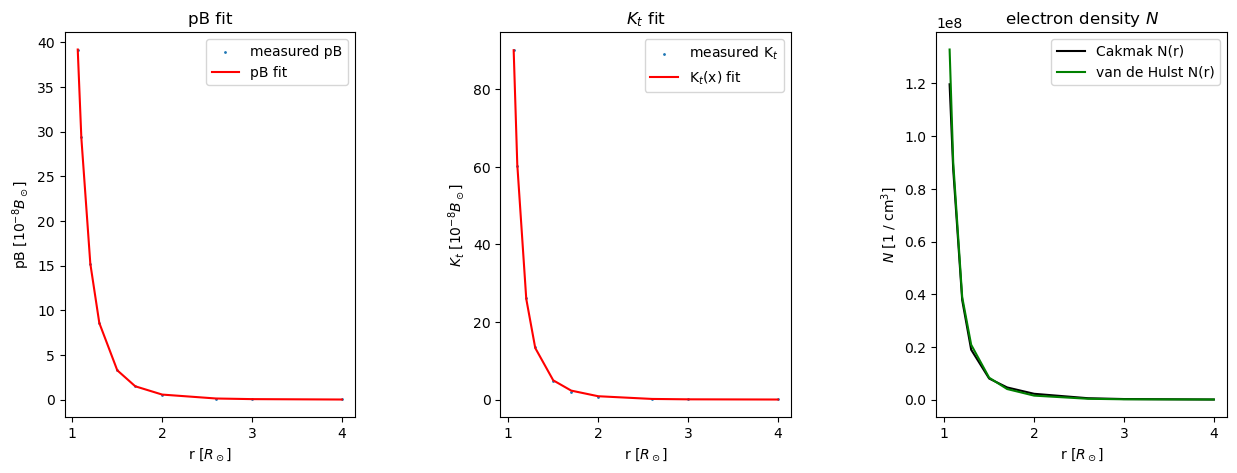

In [9]:
sorted_distances = np.array([1.06, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.6, 3, 4])
sorted_tB = np.array([141.3, 91.1, 37.1, 18.5, 6.2, 2.57, 0.852, 0.162, 0.0711, 0.185])
pol = np.array([0.277, 0.323, 0.408, 0.463, 0.538, 0.588, 0.625, 0.658, 0.647, 0.607])
sorted_pB = pol * sorted_tB
N_vdh = np.array([132.9, 90.1, 38.9, 20.8, 8.3, 4, 1.5, 0.3, 0.1, 0.02]) * 10 **6

sorted_Kt = (sorted_tB + sorted_pB)/2

A,B = A_and_B(sorted_distances)

deg = 3

pB_coeffs, pB_exps = RSS_regression(residuals, sorted_distances, sorted_pB, deg, np.linspace(1, 10, 5))
Kt_coeffs, Kt_exps = RSS_regression(residuals, sorted_distances, sorted_Kt, deg, np.linspace(1, 10, 10))

pB_x_regression = custom_polynomial(sorted_distances, pB_coeffs, pB_exps)
Kt_x_regression = custom_polynomial(sorted_distances, Kt_coeffs, Kt_exps)

pB_rad = pB_r(sorted_distances, *pB_coeffs, *pB_exps)
Kt_rad = Kt_r(sorted_distances, *Kt_coeffs,*Kt_exps)

N_t = Kt_rad / sorted_distances / C / A
N_t_r = pB_rad / sorted_distances / C / (A - B)
N_r =(2 * N_t - N_t_r) 

print("maximum error ", np.max(np.abs(N_vdh - N_r)/np.abs(N_vdh)) * 100,"%")
print("minimum error ", np.min(np.abs(N_vdh - N_r)/np.abs(N_vdh)) * 100,"%")
print("average error ", np.mean(np.abs(N_vdh - N_r)/np.abs(N_vdh)) * 100,"%")

plt.figure(figsize = [15, 5])   
plt.subplot(1,3,1)
plt.scatter(sorted_distances, sorted_pB, s=1, label='measured pB')
plt.plot(sorted_distances, pB_x_regression, "-r", label = "pB fit")
plt.title("pB fit")
plt.xlabel("r [$R_\odot$]")
plt.ylabel("pB [$10^{-8}B_\odot$]")  
plt.legend()   
    
plt.subplot(1,3,2)
plt.scatter(sorted_distances, sorted_Kt, s=1, label='measured K$_t$')
plt.plot(sorted_distances, Kt_x_regression, "-r", label = "K$_t$(x) fit")
plt.title("$K_t$ fit ")
plt.xlabel("r [$R_\odot$]")
plt.ylabel("$K_t$ [$10^{-8}B_\odot$]")  
plt.legend()   

plt.subplot(1,3,3)
plt.plot(sorted_distances, N_r, 'k-', label='Cakmak N(r)')
plt.plot(sorted_distances, N_vdh, 'g-', label='van de Hulst N(r)')
plt.title("electron density $N$")
plt.xlabel("r [$R_\odot$]")
plt.ylabel("$N$ [1 / cm$^3$]")  
plt.legend()   
plt.subplots_adjust(wspace=0.5, hspace=0.5)

With a polar image given, the following function takes the average of the inversion performed on several columns and compresses the values in one column

In [10]:
def average_columns(matrix, n):
    # Check if the number of columns is a multiple of n
    if matrix.shape[1] % n != 0:
        raise ValueError("The number of columns in the matrix must be a multiple of n.")
    
    # Number of columns in the original matrix
    original_columns = matrix.shape[1]
    
    # Number of columns in the new matrix
    new_columns = original_columns // n
    
    # Initialize the new matrix with the same number of rows and the reduced number of columns
    new_matrix = np.zeros((matrix.shape[0], new_columns))
    
    # Calculate the average for each set of n columns
    for i in range(new_columns):
        start_col = i * n
        end_col = start_col + n
        new_matrix[:, i] = np.mean(matrix[:, start_col:end_col], axis=1)
    
    return new_matrix

Core cell of this notebook: for each center shift in "delta_cen", transforms the pB_image in a polar one, performs a RSS least-square method, and then computes the electron density $N_e$

In [11]:
in_fov = hdu_Metis_pB.header['INN_FOV']*3600/hdu_Metis_pB.header['RSUN_ARC'] 
out_fov = hdu_Metis_pB.header['OUT_FOV']*3600/hdu_Metis_pB.header['RSUN_ARC'] 

in_fov = in_fov + 0.4 # rsun # to cut background and Venus at inner part of the Metis FOV
out_fov = out_fov - 0.6 # rsun # to cut hot pixels at outer part of the Metis FOV

window_ROIrho = np.logical_and(rho_suncen > in_fov, rho_suncen < out_fov) # [pixel]

start_angle = 0                          # ROI angles definition
end_angle = 360
step_per_1deg = 1

impact_x = np.linspace(in_fov, out_fov, off_el_pol_img.shape[0])
A, B = A_and_B(impact_x)

avg_rel_err = 0 # to keep track of the average of the average relative error of my electron density, wrt to the official one

# list of tuples, where each tuple is the delta we want our center to shift
delta_cen = [(-1, 0), (1, 0)]

electron_polar_img = np.zeros((len(delta_cen), len(impact_x), end_angle-start_angle)) 
start_time = time.time()
for i, delta in enumerate(delta_cen):
        X_CEN = hdu_Metis_pB.header['SUNPIX1'] + delta[0]
        Y_CEN = hdu_Metis_pB.header['SUN_YCEN'] + delta[1]
        
        rho_suncen = np.sqrt((X-X_CEN)**2 + (Y-Y_CEN)**2) / R_sun_pixel # [pixel]
        phi_suncen = (np.arctan2((Y-Y_CEN), (X-X_CEN))*(180/np.pi)+360)%360  # [deg]

        for j, angle in enumerate(np.linspace(start_angle, end_angle,  (end_angle - start_angle) * step_per_1deg, endpoint = False)):
            phi_i = angle
            phi_j = angle + 1 / step_per_1deg
        
            "---------- START of the image reading part --------------"
            window_ROIphi = np.logical_and(phi_suncen >= phi_i, phi_suncen < phi_j) # [degree]
            # indexes where both masks are True: 
            index = np.where(np.logical_and(window_ROIrho, window_ROIphi))
            
            # combine the masks into tuples to iterate
            index_yx = zip(index[0], index[1])
            
            distances = []
            pB = []
            tB = []
        
            # get the values where the windows holds
            for y, x in index_yx:
                if not np.isnan(hdu_Metis_pB.data[y][x]):
                    pB.append(hdu_Metis_pB.data[y][x])
                    distances.append(rho_suncen[y][x])
                    tB.append(hdu_Metis_tB.data[y][x])
        
            tB = np.array(tB)
            pB = np.array(pB) 
            distances = np.array(distances) 
        
            # For Cakmak 2023 to work properly the brightness must be expressed in terms of 10^-8*$B_\odot$
            pB = pB * 10 ** 8
            tB = tB * 10 ** 8
            
            # sorting the distances in increasing order with the respective pB and tB
            zipped_val = zip(distances, pB, tB)
            zipped_val = sorted(zipped_val, key=lambda x: x[0])
        
            # unzip after sorting
            sorted_distances, sorted_pB, sorted_tB = zip(*zipped_val)
            
            sorted_distances = np.array(sorted_distances) 
            sorted_pB = np.array(sorted_pB)
            sorted_tB = np.array(sorted_tB)
        
            # replacing the pixels with negative brightness with the mean value of the positive pixels
            sorted_pB[sorted_pB < 0] = np.mean(sorted_pB[sorted_pB >= 0])
            sorted_tB[sorted_tB < 0] = np.mean(sorted_tB[sorted_tB >= 0])
            "---------- END of the image reading part, START of the data analysis part -----------" 
        
            # Create a denser array
            x_dense = np.linspace(impact_x[0], impact_x[-1], num=len(sorted_distances))  
            interpolator = interp1d(impact_x, off_K_pol[:, int(angle)], kind='cubic') 
            K_dense = interpolator(x_dense)
        
            # We have to clean tB from the F corona contribution 
            sorted_Kt = (sorted_pB + K_dense) / 2
        
            # Implementing a Residual Sum of Squares (RSS) method: 
            
            # desired degree of the custom_polynomial function, as for Cakmak 2023 deg = 3 is set
            deg = 3
        
            pB_coeffs, pB_exps = RSS_regression(residuals, sorted_distances, sorted_pB, deg, np.linspace(1, 7, 5))
            Kt_coeffs, Kt_exps = RSS_regression(residuals, sorted_distances, sorted_Kt, deg, np.linspace(1, 7, 5))
            
            pB_x_regression = custom_polynomial(impact_x, pB_coeffs, pB_exps)
            Kt_x_regression = custom_polynomial(impact_x, Kt_coeffs, Kt_exps)
        
            pB_rad = pB_r(impact_x, *pB_coeffs, *pB_exps)
            Kt_rad = Kt_r(impact_x, *Kt_coeffs,*Kt_exps)
        
            N_t = Kt_rad / impact_x / C / A
            N_t_r = pB_rad / impact_x / C / (A - B)
            N_r =(2 * N_t - N_t_r) 
            
            # if np.any(N_r < 0):
            #     N_r[:] = 0
        
            N_r = np.array(N_r)
            
            electron_polar_img[i, :, j] = N_r
        
            # rel_err = np.mean((N_r - off_el_pol_img[:, int(angle)])/np.abs(off_el_pol_img[:, int(angle)])) * 100
            # avg_rel_err = avg_rel_err + rel_err
            #print("average error ", rel_err,"%")
            clear_output()
            print("Image "+str(int(i + 1))+" of "+str(len(delta_cen)) + ": " + str(phi_i + 1) + "/360 deg", flush = True)
        
            "----------- END, of the data analysis part, START of the plotting part -------------"

            # Uncomment to show regression for each radial. Advice: do this only for a limited number of radials, computationally expensive and time consuming.
            
            # plt.figure(figsize = [15, 5])   
            # plt.subplot(1,3,1)
            # plt.scatter(sorted_distances, sorted_pB, s=1, label='measured pB')
            # plt.scatter(sorted_distances, sorted_tB, s=1, c = "k", alpha = 0.5, label='measured $tB$')
            # plt.plot(impact_x, pB_x_regression, "-r", label = "pB(r) RSS")
            # plt.plot(sorted_distances, sorted_tB - K_dense, "-g", alpha=0.5, label = "F-corona model")
            # plt.title("pB fit: " + str(round(phi_i,2))+" deg-"+str(round(phi_j,2))+" deg")
            # plt.xlabel("r [$R_\odot$]")
            # plt.ylabel("pB [$10^{-8}B_\odot$]")  
            # plt.legend()   
                
            # plt.subplot(1,3,2)
            # plt.scatter(sorted_distances, sorted_Kt, s=1, label='measured K$_t$')
            # plt.plot(impact_x, Kt_x_regression, "-r", label = "K$_t$(x) RSS")
            # plt.title("$K_t$ fit " + str(round(phi_i,2))+" deg-"+str(round(phi_j,2))+" deg")
            # plt.xlabel("r [$R_\odot$]")
            # plt.ylabel("$K_t$ [$10^{-8}B_\odot$]")  
            # plt.legend()   
            
            # plt.subplot(1,3,3)
            # plt.plot(impact_x, N_r, 'k-', label='Cakmak N(r)')
            # plt.plot(np.linspace(in_fov, out_fov, off_el_pol_img.shape[0]), off_el_pol_img[:, int(angle)], 'b--', label='Official N(r)')
            # plt.title("electron density $N$: " + str(round(phi_i,2))+" deg-"+str(round(phi_j,2))+" deg")
            # plt.xlabel("r [$R_\odot$]")
            # plt.ylabel("$N$ [1 / cm$^3$]")  
            # plt.legend()   
            # plt.subplots_adjust(wspace=0.5, hspace=0.5)
            # plt.savefig(r'C:\Users\Lenovo1\Desktop\tesi3_Dario\comparison_plots')

# print("average of average relative errors", avg_rel_err / (end_angle - start_angle), "%")
print("elapsed time: ", time.time() - start_time, " s")

Image 2 of 2: 360.0/360 deg
elapsed time:  517.3700444698334  s


## Comparisons

to avoid overwriting the just obtained electron density image. Run this cell with caution!!!

In [12]:
copy_el_pol_img = electron_polar_img

Plots the comparison with Burtovoi's code electron density:

-327.87321629558414


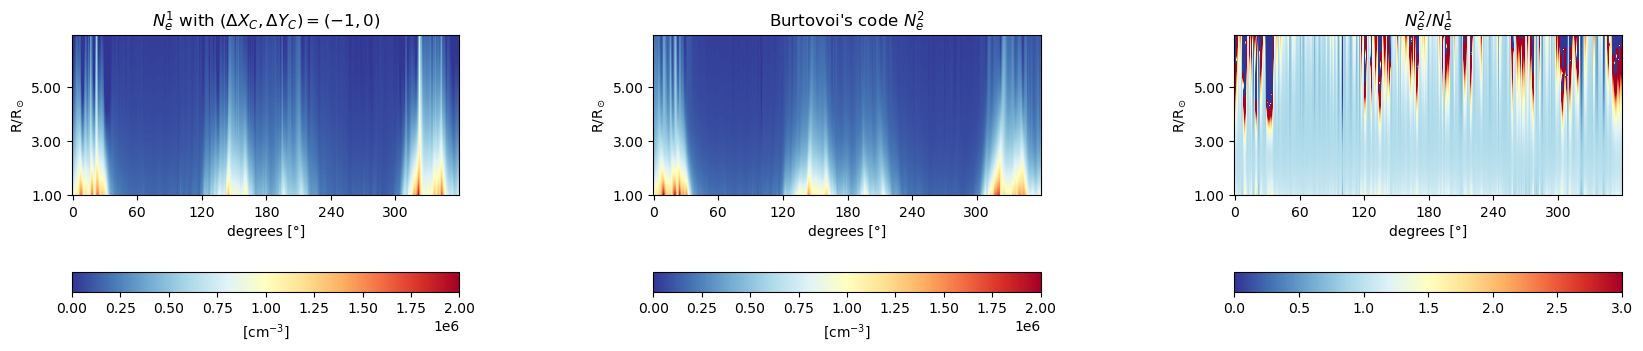

In [16]:
# copy_el_pol_img = np.delete(copy_el_pol_img, 0, axis=1)
# copy_el_pol_img = average_columns(copy_el_pol_img, step_per_1deg)
# copy_el_pol_img = permute_n_columns(copy_el_pol_img, int(hdu_Metis_pB.header['CROTA'])) 
print(np.mean(copy_el_pol_img[1] - copy_el_pol_img[0]))

plt.figure(figsize=(20,10))
# plt.tight_layout()
ax3_1 = plt.subplot(1, 3, 1)
ax3_1.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_1.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_1.set_title("$N_e^1$ with $(\Delta X_C, \Delta Y_C) = (-1, 0)$")
ax3_1.set_yticks(np.arange(0, len(impact_x
+1), 50))
ax3_1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x
+1), 50)))])
ax3_1.set_xlabel('degrees [°]')
ax3_1.set_ylabel('R/R$_\odot$')
image_ne = ax3_1.imshow((copy_el_pol_img[0]) , cmap = METIS_VL_CMAP, vmin=0.0, vmax=2e6, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_1, shrink = 1, orientation = 'horizontal', pad = 0.1)
cbar.ax.yaxis.set_major_formatter('{:.1e}'.format)
cbar.set_label('[cm$^{-3}]$')

# ax3_2 = plt.subplot(1, 3, 2)
# ax3_2.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
# ax3_2.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
# ax3_2.set_yticks(np.arange(0, len(impact_x+1), 50))
# ax3_2.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x
# +1), 50)))])
# ax3_2.set_xlabel('degrees [°]')
# ax3_2.set_ylabel('R/R$_\odot$')
# ax3_2.set_title("$N_e^2$ with $(\Delta X_C, \Delta Y_C) = (+1, 0)$")
# image_ne = ax3_2.imshow((copy_el_pol_img[1]) , cmap = METIS_VL_CMAP, vmin=0.0, vmax=2e6, origin = "lower")
# cbar = plt.colorbar(image_ne, ax = ax3_2, shrink = 1, orientation = 'horizontal', pad = 0.1)
# cbar.ax.yaxis.set_major_formatter('{:.1e}'.format)
# cbar.set_label('[cm$^{-3}]$')

ax3_2 = plt.subplot(1, 3, 2)
ax3_2.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_2.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_2.set_yticks(np.arange(0, len(impact_x+1), 50))
ax3_2.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x
+1), 50)))])
ax3_2.set_xlabel('degrees [°]')
ax3_2.set_ylabel('R/R$_\odot$')
ax3_2.set_title("Burtovoi's code $N_e^2$")
image_ne = ax3_2.imshow(off_el_pol_img , cmap = METIS_VL_CMAP, vmin=0.0, vmax=2e6, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_2, shrink = 1, orientation = 'horizontal', pad = 0.1)
cbar.ax.yaxis.set_major_formatter('{:.1e}'.format)
cbar.set_label('[cm$^{-3}]$')

# cbar=m.colorbar(trend, size='3%',ticks=bounds,extend="max")
ax3_3 = plt.subplot(1, 3, 3)
ax3_3.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_3.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_3.set_title("$ N_e^2 / N_e^1 $")
ax3_3.set_yticks(np.arange(0, len(impact_x+1), 50))
ax3_3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x+1), 50)))])
ax3_3.set_xlabel('degrees [°]')
ax3_3.set_ylabel('R/R$_\odot$')
image_ne = ax3_3.imshow( off_el_pol_img / copy_el_pol_img[0], cmap = METIS_VL_CMAP, vmin=0, vmax= 3, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_3, shrink = 1, orientation = 'horizontal', pad = 0.1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
# cbar.set_label()

plt.savefig(r'C:\Users\Lenovo1\Desktop\tesi3_Dario\immagini codice\comparison_my_vs_Burtovoi_Ne_ratio',bbox_inches='tight')

Comparison between the electron densities from the same image, but with different center shifts

-327.87321629558414


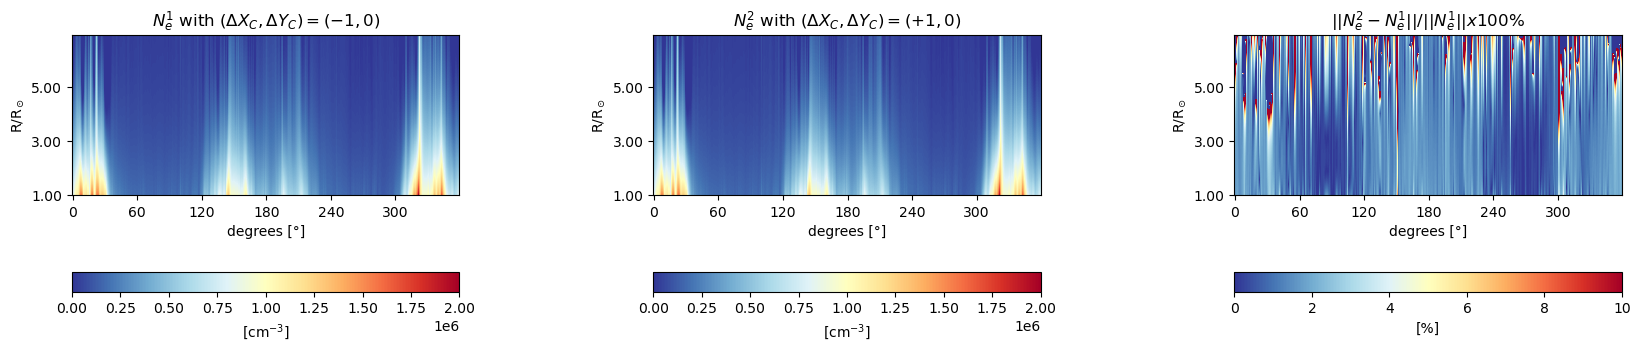

In [20]:
# copy_el_pol_img = np.delete(copy_el_pol_img, 0, axis=1)
# copy_el_pol_img = average_columns(copy_el_pol_img, step_per_1deg)
# copy_el_pol_img = permute_n_columns(copy_el_pol_img, int(hdu_Metis_pB.header['CROTA'])) 
print(np.mean(copy_el_pol_img[1] - copy_el_pol_img[0]))

plt.figure(figsize=(20,10))
# plt.tight_layout()
ax3_1 = plt.subplot(1, 3, 1)
ax3_1.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_1.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_1.set_title("$N_e^1$ with $(\Delta X_C, \Delta Y_C) = (-1, 0)$")
ax3_1.set_yticks(np.arange(0, len(impact_x
+1), 50))
ax3_1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x
+1), 50)))])
ax3_1.set_xlabel('degrees [°]')
ax3_1.set_ylabel('R/R$_\odot$')
image_ne = ax3_1.imshow((copy_el_pol_img[0]) , cmap = METIS_VL_CMAP, vmin=0.0, vmax=2e6, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_1, shrink = 1, orientation = 'horizontal', pad = 0.1)
cbar.ax.yaxis.set_major_formatter('{:.1e}'.format)
cbar.set_label('[cm$^{-3}]$')

ax3_2 = plt.subplot(1, 3, 2)
ax3_2.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_2.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_2.set_yticks(np.arange(0, len(impact_x+1), 50))
ax3_2.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x
+1), 50)))])
ax3_2.set_xlabel('degrees [°]')
ax3_2.set_ylabel('R/R$_\odot$')
ax3_2.set_title("$N_e^2$ with $(\Delta X_C, \Delta Y_C) = (+1, 0)$")
image_ne = ax3_2.imshow((copy_el_pol_img[1]) , cmap = METIS_VL_CMAP, vmin=0.0, vmax=2e6, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_2, shrink = 1, orientation = 'horizontal', pad = 0.1)
cbar.ax.yaxis.set_major_formatter('{:.1e}'.format)
cbar.set_label('[cm$^{-3}]$')

# cbar=m.colorbar(trend, size='3%',ticks=bounds,extend="max")
ax3_3 = plt.subplot(1, 3, 3)
ax3_3.set_xticks(np.arange(0, end_angle*step_per_1deg+1, 60))
ax3_3.set_xticklabels(np.arange(0, 361, 60/(end_angle*step_per_1deg/360)).astype(int))
ax3_3.set_title("$||N_e^2 - N_e^1|| / ||N_e^1|| x 100\%$")
ax3_3.set_yticks(np.arange(0, len(impact_x+1), 50))
ax3_3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(round(in_fov)-1, round(out_fov)+1, len(np.arange(0, len(impact_x+1), 50)))])
ax3_3.set_xlabel('degrees [°]')
ax3_3.set_ylabel('R/R$_\odot$')
image_ne = ax3_3.imshow(np.abs(copy_el_pol_img[1] - copy_el_pol_img[0]) / copy_el_pol_img[0] * 100, cmap = METIS_VL_CMAP, vmin=0, vmax= 10, origin = "lower")
cbar = plt.colorbar(image_ne, ax = ax3_3, shrink = 1, orientation = 'horizontal', pad = 0.1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
cbar.set_label("[%]")

plt.savefig(r'C:\Users\Lenovo1\Desktop\tesi3_Dario\immagini codice\cfr_delta_cen_m10_10_perc',bbox_inches='tight')

# F-corona model definition

The main problem with the previous method for $N_e$ calculation is the use of the model F-corona evaluated directly from Burtovoi's code which uses [Hayes 2001] inversion method. This method shows some critical issues, as addressed in [Burtovoi 2021], so the Leinert-Mann model for the F-corona brightness is introduced. This model will be generalized by Y. De Leo in a future work, to consider the images coming from Solar Orbiter in the out-of-ecliptic phases of its mission profile.

- [Burtovoi 2021]: Burtovoi, A. et al. (Dec. 2021). Measuring the F-corona intensity through
time correlation of total and polarized visible light images
- [Hayes 2001]: Hayes, A. P., A. Vourlidas, and R. A. Howard (Feb. 2001). “Deriving the
Electron Density of the Solar Corona from the Inversion of Total Bright-
ness Measurements”. In: The Astrophysical Journal 548.2, pp. 1081–
1086..

In [15]:
# DEFINITION OF THE LEINERT-MANN MODEL FOR THE F-CORONA

" constants' definition "
F0 = 1.367*10**6 # [erg / cm^2 / s] Solar constant @ 1 AU
R0 = 1 # [AU]
  